In [1]:
import jax
import jax.numpy as jnp
import jax.lax as lax
import matplotlib.pyplot as plt


from scipy.integrate import simpson
import numpy as np
import pymaster as nmt
import healpy as hp
import gc
import time
from tqdm import tqdm


from utils2 import *
%matplotlib inline

In [2]:
def build_binning_matrix(edges, lmax):
    nbins = len(edges) - 1
    lmin = edges[0]
    B = np.zeros((nbins, lmax - lmin))
    ell_eff = np.zeros(nbins)
    for b in range(nbins):
        ell_min, ell_max = edges[b], edges[b + 1]
        ells_in_bin = np.arange(ell_min, ell_max)
        Δℓ = len(ells_in_bin)
        if Δℓ > 0:
            B[b, ells_in_bin - lmin] = 1.0 / Δℓ
            ell_eff[b] = np.mean(ells_in_bin)
    return B, ell_eff


def pad_binning_matrix(B, lmax_full, lmin=0):
    nbins, ncols = B.shape
    B_padded = np.zeros((nbins, lmin + ncols))
    B_padded[:, :ncols] = B
    return B_padded

In [3]:
deg = jnp.pi / 180.0

def cos_theta_pair(gl_i, gb_i, gl_j, gb_j):
    return (
        jnp.sin(gb_i) * jnp.sin(gb_j)
        + jnp.cos(gb_i) * jnp.cos(gb_j) * jnp.cos(gl_i - gl_j)
    )

# This funciton applies the operation from the ith index one-by-one to the jth index.
cos_theta_row = jax.vmap(
    cos_theta_pair,
    in_axes=(None, None, 0, 0)
)


# This function applies the 
cos_theta_matrix = jax.vmap(
    cos_theta_row,
    in_axes=(0, 0, None, None)
)

@jax.jit
def compute_cos_theta(gl, gb):
    return cos_theta_matrix(gl * deg, gb * deg,
                             gl * deg, gb * deg)

In [ ]:
def symmetry_fac(i, j, a, b):
    if i == j and a == b:
        return 1.0
    else:
        return 2.0

In [ ]:
n_sources = [10000]

partition = 5000

nside = 256
npix = hp.nside2npix(nside)
sel = np.ones(npix)

nell = 20
lmin = 2
lmax_nside = 3*nside - 1
lmax = lmax_nside
edges = np.unique(np.geomspace(lmin, lmax,nell).astype(int))
# edges = np.arange(lmin, 3*nside + 1)
cl_DMDM = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0 ,0]
alm = hp.synalm(cls=cl_DMDM, lmax = lmax_nside)
map = hp.alm2map(alm, nside=nside, lmax=lmax_nside)



variance_list = []

for n_samples in n_sources:
    print('sampling on a sphere')
    (gl ,gb),  _ = get_pos(n_samples, 'random', sel, nside)
    
    ipix = hp.ang2pix(nside, gl, gb, lonlat=True)
    w = np.ones_like(ipix)
    # beware of the binning scheme and the values to be added to the  
    b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
    f_vals = map[ipix] - np.mean(map[ipix])
    f_nmt = nmt.NmtFieldCatalog(positions = [gl, gb], weights=w, field = f_vals, lmax=b.lmax, lonlat=True)
    wasp = nmt.NmtWorkspace.from_fields(f_nmt, f_nmt, b)
    
    
    Sl_coupled = nmt.compute_coupled_cell(f_nmt, f_nmt) # the coupled, noise subtracted power spectrum 
    Nf = f_nmt.Nf
    Sl = wasp.decouple_cell(Sl_coupled)
    ells = b.get_effective_ells()
    
    
    Binning, ell_eff = build_binning_matrix(edges, edges[-1])
    Binning_matrix_padded = pad_binning_matrix(Binning, lmax, lmin)
    Binning_matrix_padded = jnp.array(Binning_matrix_padded)
    
    
    mcm = jnp.asarray(wasp.get_coupling_matrix())
    mcm_inv = np.linalg.inv(mcm)
    var_f = np.var(f_vals)

    # Recurrence: (l+1) P_{l+1} = (2l+1)x P_l - l P_{l-1}
    
    
    
    for i in range(n_samples // partition):
        gl_i = gl[i*partition:(i+1)*partition]
        gb_i = gb[i*partition:(i+1)*partition]
        for j in range(i+ 1):
            gl_j = gl[j*partition:(j+1)*partition]
            gb_j = gb[j*partition:(j+1)*partition]
            for a in range(n_samples // partition):
                gl_a = gl[a*partition:(a+1)*partition]
                gb_a = gb[a*partition:(a+1)*partition]
                for b in range(a + 1):
                    gl_b = gl[b*partition:(b+1)*partition]
                    gb_b = gb[b*partition:(b+1)*partition]

                    cos_theta_ij = compute_cos_theta(gl_i, gb_j)
                    cos_theta_ab = compute_cos_theta(gl_a, gb_a)
                    
                    cos_theta_ia = compute_cos_theta(gl_i, gb_a)
                    cos_theta_jb = compute_cos_theta(gl_j, gb_b)
                    
                    carry_init_ij = (jnp.ones_like(cos_theta_ij), cos_theta_ij)
                    def body_fn(carry, l):
                        P_lm1, P_l = carry
                        P_lp1 = ((2*l + 1)*cos_theta_ij*P_l - l*P_lm1) / (l + 1)
                        return (P_l, P_lp1), P_lp1

                    # Run scan from l=1 to Lmax-1
                    _, P_ij = lax.scan(body_fn, carry_init_ij, jnp.arange(2, edges[-1]))
                    P_ij = jnp.concatenate([
                        jnp.ones_like(cos_theta_ij)[None, :],   # P_0
                        cos_theta_ij[None, :],                  # P_1
                        P_ij                        # P_2 ... P_Lmax
                    ], axis=0)
                    
                    def body_fn(carry, l):
                        P_lm1, P_l = carry
                        P_lp1 = ((2*l + 1)*cos_theta_ab*P_l - l*P_lm1) / (l + 1)
                        return (P_l, P_lp1), P_lp1
                    
                    carry_init_ab = (jnp.ones_like(cos_theta_ab), cos_theta_ab)

                    # Run scan from l=1 to Lmax-1
                    _, P_ab = lax.scan(body_fn, carry_init_ab, jnp.arange(2, edges[-1]))
                    P_ab = jnp.concatenate([
                        jnp.ones_like(cos_theta_ab)[None, :],   # P_0
                        cos_theta_ab[None, :],                  # P_1
                        P_ab                        # P_2 ... P_Lmax
                    ], axis=0)
                    
                    
                    
                    
                    
                    

    gc.collect()
    
    
    
    
    
    
    # Initialize P_0 = 1, P_1 = x
    


    
    TB = Binning_matrix_padded @ mcm_inv
    TBP = jnp.einsum('la, aij->lij', TB, P_all)
    
    gc.collect()
    
    
    full_ells = jnp.arange(0, edges[-1])
    
    Sl_unbinned = b.unbin_cell(Sl)[0]
    signal_corr = jnp.einsum('l, lij->ij', (2*full_ells + 1) *Sl_unbinned, P_all)/4./np.pi
    
    del P_all
    
    
    
    unit_matrix = np.zeros((n_samples, n_samples))
    
    
    
    np.fill_diagonal(unit_matrix, 1)
    
    
    field_variance = jnp.sum((2*full_ells + 1)*Sl_unbinned)/4./np.pi
    noise_variance = var_f - field_variance
    
    
    
    Nw = np.sum(w*w)/4./np.pi
    Nl = Nw*noise_variance
    

    # noise_corr = jnp.einsum('l, lij->ij', (2*full_ells + 1) *Nl, P_all)/4./np.pi
    noise_corr = unit_matrix*noise_variance
    full_field_corr =  signal_corr + noise_corr
    
    
    
    w_i_j = w[None, :]*w[:, None]
    np.fill_diagonal(w_i_j, 0)
    
    
    
    
    print('summing terms')
    term1_binned = 2*jnp.einsum('ij, aij, km, bkm, ik, jm->ab', w_i_j, TBP, w_i_j, TBP, full_field_corr, full_field_corr)/(4*np.pi)**2    
    
    # direct_sum = 2*jnp.einsum('ij, aij, km, bkm, ik, jm->ab', w_i_j, P_all, w_i_j, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    
    
    
    # direct_sum = 2*jnp.einsum('ij, aij, km, bkm, ik, jm->ab', w_i_j, P_all, w_i_j, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    print('Applying MCM')
    # term1 = mcm_inv @ direct_sum @ mcm_inv.T
    print('trimming the array')
    # term1 = term1[lmin:, lmin:]
    print('applying the binning scheme')
    # term1_binned = Binning_matrix_padded @ term1 @ Binning_matrix_padded.T
    variance_list.append(jnp.diag(term1_binned))
    
    # del P_all, cos_theta, full_field_corr, noise_corr, signal_corr, w_i_j, Binning, direct_sum, term1, gl, gb, ipix, f_vals, f_nmt, wasp, Sl_coupled, Sl_unbinned
    gc.collect()
    
    
    
    
'''    direct_sum2 = 2*jnp.einsum('ik, jm, i, j, ij, aij, k, m, km, bkm, ik, jm->ab', unit_matrix, unit_matrix, w, w, 1- unit_matrix, P_all, w, w, 1- unit_matrix, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    term2 = mcm_inv @ direct_sum2 @ mcm_inv.T
    term2 = term2[lmin:, lmin:]
    term2_binned = Binning @ term2 @ Binning.T
    variance_list2.append(jnp.diag(term2_binned))
    
    
    
    direct_sum3 = jnp.einsum('i, j, aij, bij->ab', w**2, w**2, P_all, P_all)/(4*np.pi)**2 - jnp.sum(w**4)/(4*np.pi)**2
    matrix_term3 = 2*direct_sum3*((var_f)**2)
    term3 = mcm_inv @ matrix_term3 @ mcm_inv.T
    term3 = term3[lmin:, lmin:]
    term3_binned = Binning @ term3 @ Binning.T
    variance_list3.append(jnp.diag(term3_binned))'''
    
    

sampling on a sphere
calculating the mode coupling matrix
calculating Paij


NameError: name 'P_all' is not defined

In [26]:
data = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_fixed_field_wide_bins.npy')
data2 = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_field_variance_wide_bins.npy')


In [27]:
ells = b.get_effective_ells()

In [28]:
import plothist

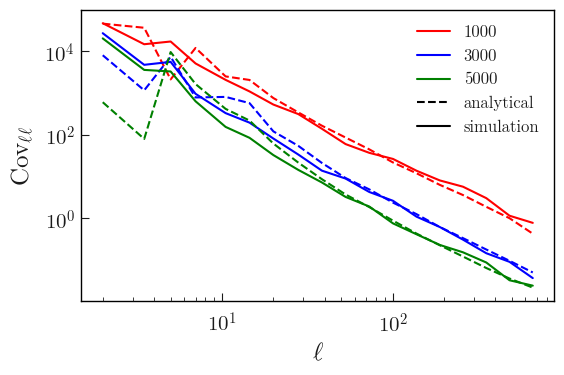

In [29]:
color = ['r', 'b', 'g']

# fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(n_sources)):
    ls, cls, sigma, Nf, _ = data[i]
    ls2, _, sigma2, _, _ = data2[i]
    
    plt.loglog(ls, sigma, color = color[i], label = n_sources[i])
    # plt.loglog(ells, sigma2, ls = ':', color = color[i])
    
    plt.loglog(ells, variance_list[i], ls = '--', color = color[i])
    
    

plt.axhline(-1, ls = '--', color = 'black', label = 'analytical')
plt.axhline(-1, color = 'black', label = 'simulation')


plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()
plt.tight_layout()
# plt.savefig('figs/full_covariance_plot.png', dpi = 300)
